In [2]:
import os
os.chdir('FASTShapelets_TS')
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/ML for Time Series/Project/FASTShapelets_TS


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from sklearn.preprocessing import StandardScaler
from utils.load_data import load_data
from utils.plot import plot_ecg_time_series
from utils.sax_representation import sax, sax_for_set, filtered_sax_for_set, plot_sax_with_breakpoints

ModuleNotFoundError: No module named 'utils'

# Chargement des données 

In [3]:
X_train, y_train = load_data(type="TRAIN")
X_test, y_test = load_data(type="TEST")

scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(x_train.reshape(-1, 1)).flatten() for x_train in X_train]
X_test_scaled = [scaler.fit_transform(x_test.reshape(-1, 1)).flatten() for x_test in X_test]

X_TRAIN shape (23, 136)
X_TEST shape (861, 136)


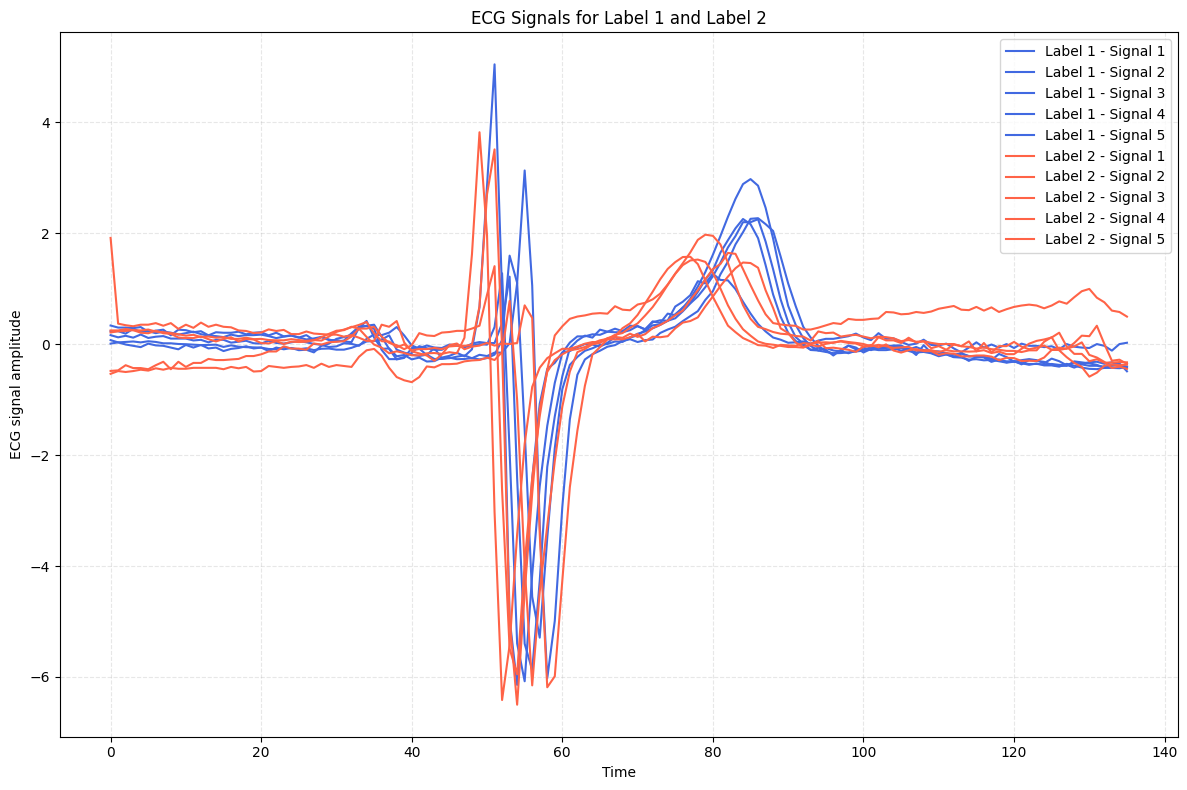

In [4]:
plot_ecg_time_series(X_train_scaled, y_train, num_series_per_class=5)


# Symbolic Aggregate approXimation (SAX): 1st method to visualize : dividing the signals into windows 
### We won't use it later 

In [5]:
# params
len_window = 17  # nb de points par fenêtre ==> length subsequence
dim_window = 4 # nouvelle dimension : taille des mots
alphabet_size = 4  # taille de l'alphabet (nombre de symboles)
stride = 1  # chevauchement (si =1, 2 windows successives on un chevauchement de len_window - 1) 

sax_results = sax_for_set(X_train_scaled, len_window, dim_window, alphabet_size, stride)

In [6]:
filtered_sax_results = filtered_sax_for_set(X_train_scaled, len_window, dim_window, alphabet_size, stride)

In [7]:
print(len(sax_results[0]))
print(len(filtered_sax_results[0]))

120
37


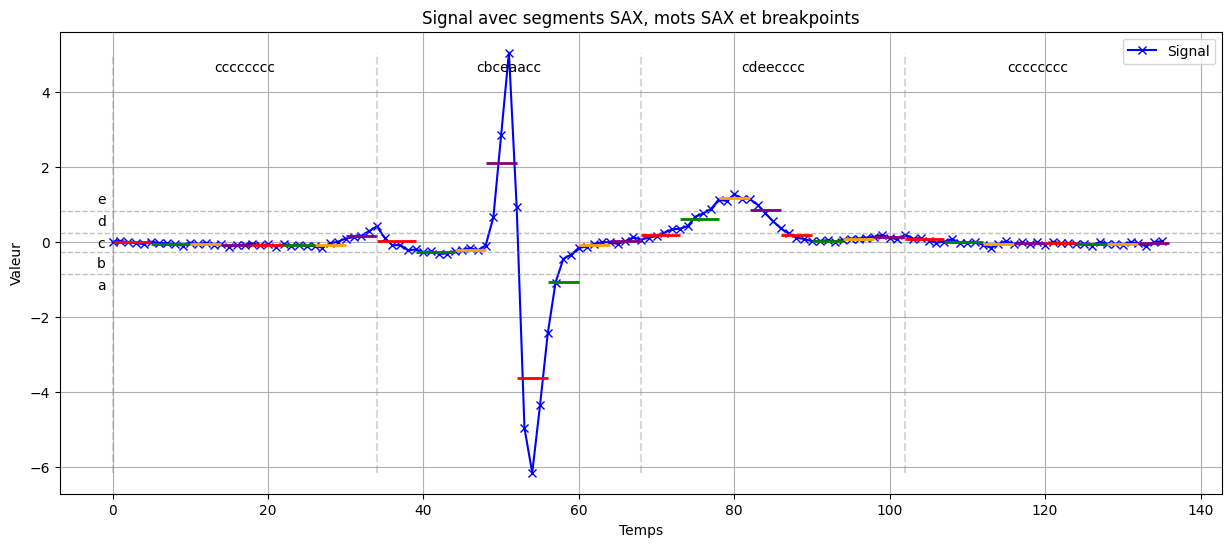

In [8]:
# Exemple SAX SANS CHEVAUCHEMENT 
signal = X_train_scaled[0]

len_window = 34
dim_window = 8 # nouvelle dimension
alphabet_size = 5
stride = 34 # pas de chevauchement pour une meilleure visibilité

# Générer les mots SAX
sax_words, windows, breakpoints = sax(signal, len_window, dim_window, alphabet_size, stride)
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g'][:alphabet_size]

# Afficher le signal et les valeurs SAX
plot_sax_with_breakpoints(signal, sax_words, windows, len_window, dim_window, stride, breakpoints, alphabet)


# Symbolic Aggregate approXimation (SAX): 2nd method using the sliding window technique


In [9]:
from utils.sax_representations_bruteforce import sax_bf, sax_for_set_bf, filtered_sax_for_set_bf

In [10]:
# params
subsequence_length = 34
word_length = 5 
alphabet_size = 4

sax_results, all_subsequences  = sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

# renvoie les différents SAX word pour chaque signal ainsi que la liste des "vrais" signaux correspondants 
filtered_sax_results, filtered_all_subsequences = filtered_sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

In [11]:
print(len(sax_results[0]))
print(len(filtered_sax_results[0]))

102
47


# Random projection and hashing 

In [12]:
from utils.sax_representations_bruteforce import sax_bf, sax_for_set_bf, filtered_sax_for_set_bf

# params
subsequence_length = 20
word_length = 10
alphabet_size = 4

sax_results, all_subsequences  = sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

# renvoie les différents SAX word pour chaque signal ainsi que la liste des "vrais" signaux correspondants 
filtered_sax_results, filtered_all_subsequences = filtered_sax_for_set_bf(X_train_scaled, subsequence_length, word_length, alphabet_size)

dict_sax = {i: liste for i, liste in enumerate(filtered_sax_results)}
dict_ts = {i: liste for i, liste in enumerate(filtered_all_subsequences)}

In [13]:
from utils.random_mask import compute_collision_matrix, compute_distinguish_power, find_top_k, remap_SAX_to_TS, SAX_to_TS

In [14]:
nb_iterations = 10
mots, collision_matrix = compute_collision_matrix(nb_iterations, dict_sax)

In [18]:
distinguish_power = compute_distinguish_power(nb_iterations, collision_matrix, y_train)
top_k = find_top_k(distinguish_power,mots,k=10)

In [19]:
top_k

['bcccccbaaa',
 'ccccdaaaac',
 'bbccdddddc',
 'cccccbaaac',
 'ccccaaabcc',
 'cbcccccdaa',
 'bcccccdaaa',
 'ccccccaaab',
 'cccbaaaccc',
 'cccdccccdc']

In [16]:
sax_to_ts_dict = SAX_to_TS(filtered_sax_results, filtered_all_subsequences)
top_k_TS = remap_SAX_to_TS(top_k, sax_to_ts_dict)

# Fast Shapelet: main

In [1]:
import os
os.chdir('FASTShapelets_TS')
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/ML for Time Series/Project/FASTShapelets_TS


In [2]:
from utils.load_data import load_data
from sklearn.preprocessing import StandardScaler
from utils.main_fast_shapelet import main_fast_shapelets
from utils.eval import create_dataframe, create_decision_tree
from utils.plot import plot_decision_tree, plot_shapelet

In [3]:
# Load data 
X_train, y_train = load_data(type="TRAIN")
X_test, y_test = load_data(type="TEST")

scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(x_train.reshape(-1, 1)).flatten() for x_train in X_train]
X_test_scaled = [scaler.fit_transform(x_test.reshape(-1, 1)).flatten() for x_test in X_test]

X_TRAIN shape (23, 136)
X_TEST shape (861, 136)


In [5]:
# Compute Fast Shapelets
# params
X = X_train_scaled
y = y_train
min_length=20
max_length=100
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)

100%|██████████| 80/80 [00:06<00:00, 13.12it/s]


In [6]:
shapelets_dict = final_shapelets
metric = "eucl"
df_train = create_dataframe(X_train, shapelets_dict, metric=metric)
df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)

100%|██████████| 861/861 [00:00<00:00, 2240.56it/s]


In [7]:
max_depth = 2
model, report = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth)
print(report)

Accuracy sur le train : 1.0000
Accuracy sur le test : 0.9965
              precision    recall  f1-score   support

    Classe 1       0.99      1.00      1.00       428
    Classe 2       1.00      0.99      1.00       433

    accuracy                           1.00       861
   macro avg       1.00      1.00      1.00       861
weighted avg       1.00      1.00      1.00       861



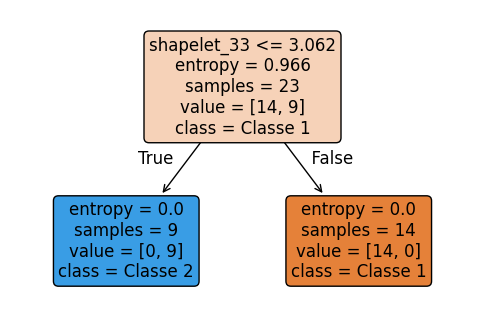

In [8]:
plot_decision_tree(model, df_train.columns.drop("Signal_nb"))

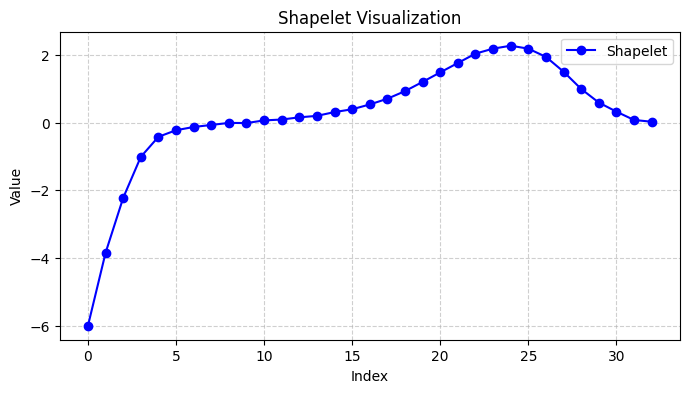

In [9]:
plot_shapelet(shapelets_dict[33])

# Test with different parameters

In [120]:
# Compute Fast Shapelets
# params
X = X_train_scaled
y = y_train
min_length=20
max_length=80
dimensionality=5
cardinality=4
r=10
k=10
metric='eucl'

final_shapelets, final_shapelets_max_gain, final_shapelets_min_gap = main_fast_shapelets(X_train_scaled, y_train, min_length=min_length, max_length=max_length, dimensionality=dimensionality, cardinality=cardinality, r=r, k=k, metric=metric)

100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


In [121]:
shapelets_dict = final_shapelets

# metric = "dtw"
df_train = create_dataframe(X_train, shapelets_dict, metric=metric)
df_test = create_dataframe(X_test_scaled, shapelets_dict, metric=metric)

23it [00:00, 31.71it/s]
861it [00:28, 30.57it/s]


In [145]:
max_depth = 1
model, report = create_decision_tree(df_train, y_train, df_test, y_test, max_depth=max_depth)
print(report)

              precision    recall  f1-score   support

    Classe 1       1.00      0.98      0.99       428
    Classe 2       0.98      1.00      0.99       433

    accuracy                           0.99       861
   macro avg       0.99      0.99      0.99       861
weighted avg       0.99      0.99      0.99       861



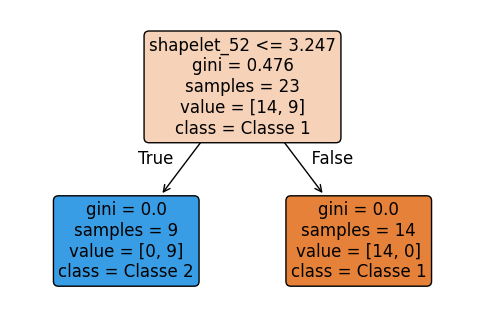

In [146]:
plot_decision_tree(model, df_train.columns.drop("Signal_nb"))

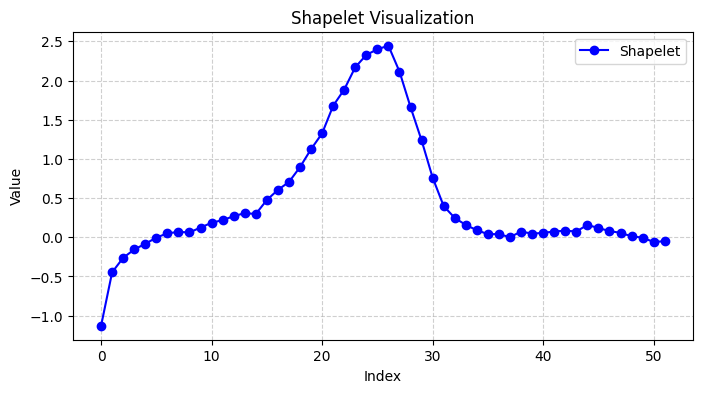

In [136]:
plot_shapelet(shapelets_dict[52]) #33, 52

# Comparison with Shapelet brute force 

In [ ]:
from tslearn.shapelets import LearningShapelets
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

In [ ]:
shapelet_sizes = range(10, 81)  # tailles de shapelets entre 10 et 100

results = {}

# Tester différentes tailles de shapelets
for size in tqdm(shapelet_sizes):
    # Initialiser le modèle avec un nombre de shapelets pour cette taille
    model = LearningShapelets(n_shapelets_per_size={size: 1})

    # Entraîner le modèle avec les données d'entraînement
    model.fit(X_train_scaled, y_train)
    
    # Calculer la précision du modèle à l'aide de la validation croisée
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)  # Utilisation de 5 plis pour la validation croisée
    
    # Enregistrer la moyenne des scores pour cette taille de shapelet
    results[size] = np.mean(cv_scores)

# Trouver la meilleure taille de shapelet en fonction des scores
best_size = max(results, key=results.get)
print(f"Meilleure taille de shapelet : {best_size} avec une précision de {results[best_size]:.4f}")

# Afficher les résultats pour toutes les tailles testées
for size, score in results.items():
    print(f"Taille de shapelet : {size}, Précision : {score:.4f}")
